# Annotate abundance changes with ClinVar labels

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style(style='white')
sns.set_palette("husl")

## 0. Load data

In [2]:
dualipa_outputs = "../3_outputs"
metadata_outputs = "../../../1_allele_collection/1_inputs"
integrative_inputs = "../../../3_integrated_assay_analyses/1_inputs/dual_ipa"
# priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]

# merge scores with metadata
scores = pl.read_csv(f"{dualipa_outputs}/DUALIPA_median_zscore.csv", separator=",", infer_schema_length=1000000)
scores = scores.filter(~pl.col("zscore_log2").is_null())

## 1. Abudance log2(z-score) dist. in each ClinVar category

### 1.1 All ClinVar variants with somewhat clear annotations (other than "Others")

ClinVar Variants Number: 741


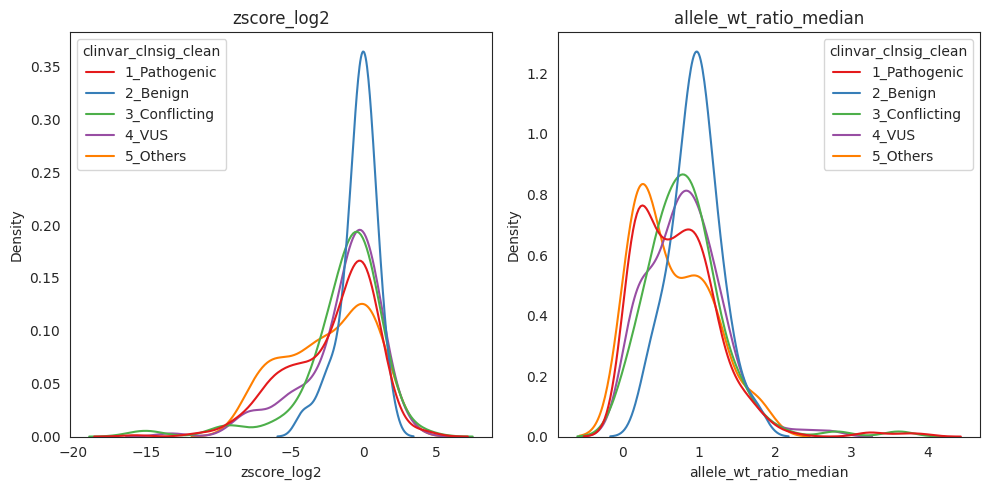

In [5]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)
print("ClinVar Variants Number:", scores.shape[0])

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores.to_pandas(),
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

### 1.2 All ClinVar variants with somewhat clear annotations (other than "Others") & _ReviewStarStatus>=1_

ClinVar Variants (StarStatus >= 1) Number: 532


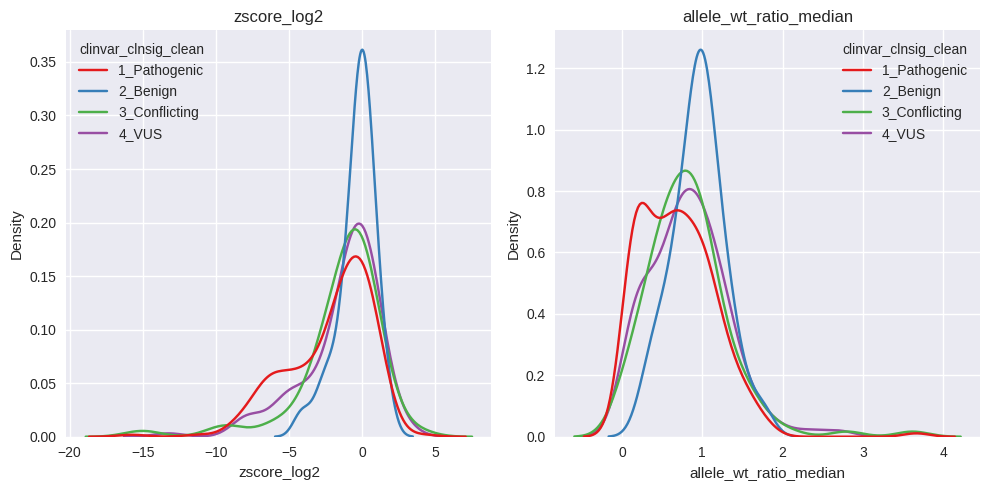

In [5]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)

scores_filt = scores.filter(pl.col("StarStatus") >= 1)
print("ClinVar Variants (StarStatus >= 1) Number:", scores_filt.shape[0])

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores_filt["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores_filt,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

# of Benign variants: 63
# of Pathogenic variants: 339
# of VUS variants: 130
# of Conflicting variants: 119


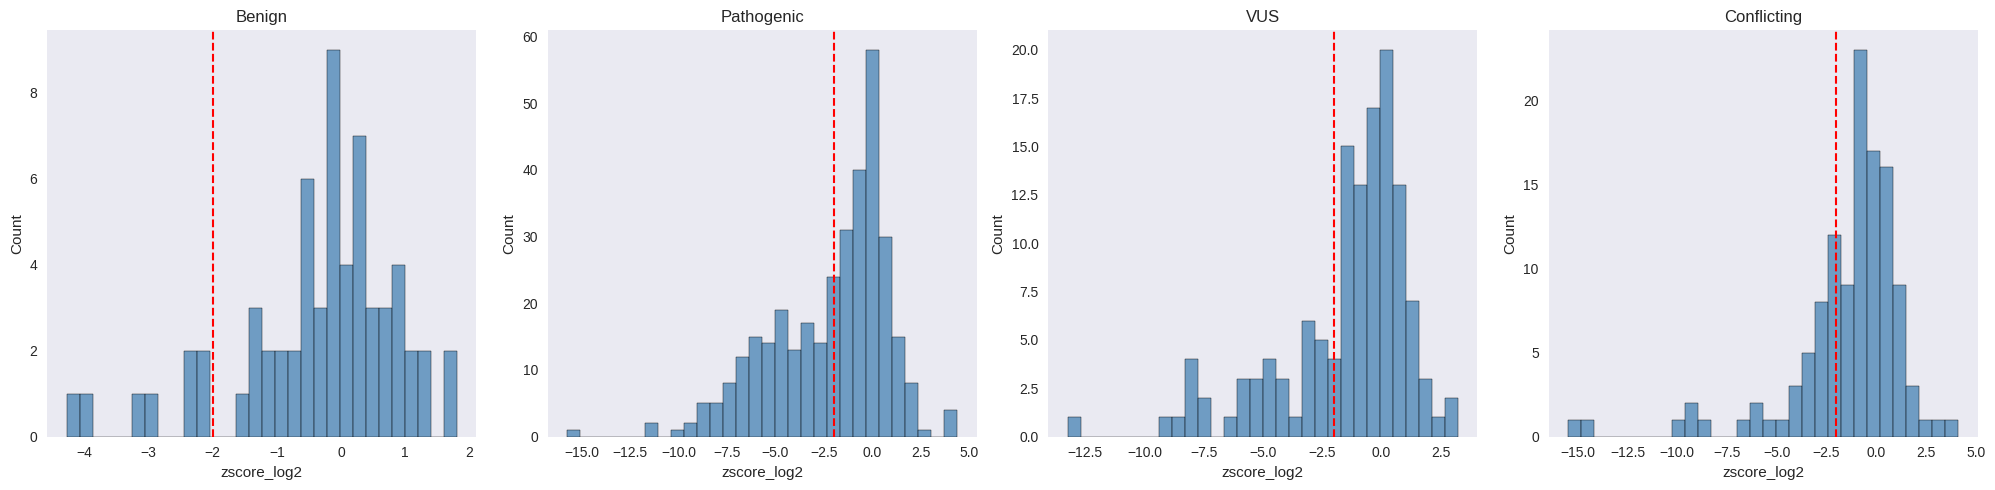

With this threshold, we classify 28.462% VUS,
AND 29.412% conflicting alleles as pathogenic.
This threshold classifies 12.698% of benign variants as pathogenic


In [6]:
plot_var = "zscore_log2"
thresh = -2

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")
print("# of Benign variants:", benign_scores.shape[0])

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic")
print("# of Pathogenic variants:", path_scores.shape[0])

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS")
print("# of VUS variants:", vus_scores.shape[0])

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting")
print("# of Conflicting variants:", conf_scores.shape[0])

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x=plot_var, bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(thresh, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel(plot_var)
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

benign_misclass = benign_scores.filter(pl.col(plot_var) < thresh).shape[0]
benign_total = benign_scores.shape[0]
print(f"With this threshold, we classify {vus_scores.filter(pl.col(plot_var) < thresh).shape[0]/vus_scores.shape[0]*100:.3f}% VUS,")
print(f"AND {conf_scores.filter(pl.col(plot_var) < thresh).shape[0]/conf_scores.shape[0]*100:.3f}% conflicting alleles as pathogenic.")
print(f"This threshold classifies {benign_misclass/benign_total*100:.3f}% of benign variants as pathogenic")
# This is ~13.4% of VUS/conflicting

In [7]:
path_scores.filter(pl.col(plot_var) < thresh).shape[0] / path_scores.shape[0]

0.41887905604719766

## 2. Find the optimal threshold for calling hits

In [44]:
class DistributionAnalyzer:
    """
    Class to analyze and compare distributions using Gaussian Mixture Models
    """
    
    def __init__(self, data_dict):
        """
        Initialize with data dictionary where keys are category names and values are arrays
        """
        self.data_dict = data_dict
        self.fitted_models = {}
        self.model_info = {}
        
    def fit_gmm(self, category, n_components_range=(1, 5), criterion='bic'):
        """
        Fit Gaussian Mixture Model with optimal number of components
        """
        data = self.data_dict[category].reshape(-1, 1)
        
        # Test different numbers of components
        scores = []
        models = []
        
        for n_comp in range(n_components_range[0], n_components_range[1] + 1):
            gmm = GaussianMixture(n_components=n_comp, random_state=42)
            gmm.fit(data)
            
            if criterion == 'bic':
                score = gmm.bic(data)
            else:  # aic
                score = gmm.aic(data)
                
            scores.append(score)
            models.append(gmm)
        
        # Select best model (lowest BIC/AIC)
        best_idx = np.argmin(scores)
        best_model = models[best_idx]
        best_n_comp = best_idx + n_components_range[0]
        
        self.fitted_models[category] = best_model
        self.model_info[category] = {
            'n_components': best_n_comp,
            'score': scores[best_idx],
            'means': best_model.means_.flatten(),
            'covariances': best_model.covariances_.flatten(),
            'weights': best_model.weights_
        }
        return best_model
    
    def fit_all_categories(self):
        """
        Fit GMM for all categories
        """
        for category in self.data_dict.keys():
            self.fit_gmm(category)
    
    def plot_distributions_with_gmm(self, figsize=(12, 7)):
        """
        Plot original distributions with fitted GMM overlays
        """
        n_categories = len(self.data_dict)
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        colors = ['red', 'blue', 'green', 'purple']
        for i, (category, data) in enumerate(self.data_dict.items()):
            ax = axes[i]
            
            # Plot histogram
            ax.hist(data, bins=50, density=True, alpha=0.6, 
                    color=colors[i], label=f'{category} (Data)')
            
            # Plot fitted GMM
            if category in self.fitted_models:
                x_range = np.linspace(data.min(), data.max(), 1000)
                gmm = self.fitted_models[category]
                
                # Overall GMM
                log_prob = gmm.score_samples(x_range.reshape(-1, 1))
                prob = np.exp(log_prob)
                ax.plot(x_range, prob, color='black', linewidth=2, 
                       label=f'GMM ({self.model_info[category]["n_components"]} components)')
                
                # Individual components
                for j in range(gmm.n_components):
                    component_prob = gmm.weights_[j] * stats.norm.pdf(
                        x_range, 
                        gmm.means_[j, 0], 
                        np.sqrt(gmm.covariances_[j, 0, 0])
                    )
                    ax.plot(x_range, component_prob, '--', alpha=0.7,
                           label=f'Component {j+1}')
            
            ax.set_title(f'{category}')
            ax.set_xlabel(r'Z-score ($log_2(FC)$)')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)

        xlim = axes[0].get_xlim()
        for i, ax in enumerate(axes):
            ax.set_xlim(xlim)
        
        plt.tight_layout()
        plt.show()
    
    def compare_with_null(self, null_category='2_Benign'):
        """
        Compare all distributions with the null distribution (2_Benign)
        """
        if null_category not in self.fitted_models:
            raise ValueError(f"Null category {null_category} not found in fitted models")
        
        null_model = self.fitted_models[null_category]
        results = {}
        
        for category, model in self.fitted_models.items():
            if category == null_category:
                continue
                
            # Calculate KL divergence
            kl_div = self._calculate_kl_divergence(null_model, model)
            
            # Identify extra peaks
            extra_peaks = self._identify_extra_peaks(null_model, model, category)
            
            results[category] = {
                'kl_divergence': kl_div,
                'extra_peaks': extra_peaks,
                'n_components': self.model_info[category]['n_components'],
                'null_n_components': self.model_info[null_category]['n_components']
            }
        
        return results
    
    def _calculate_kl_divergence(self, model1, model2, n_samples=10000):
        """
        Calculate KL divergence between two GMM models
        """
        # Sample points for comparison
        data_range = np.linspace(-25, 5, n_samples).reshape(-1, 1)
        
        # Get log probabilities
        log_prob1 = model1.score_samples(data_range)
        log_prob2 = model2.score_samples(data_range)
        
        # Convert to probabilities and normalize
        prob1 = np.exp(log_prob1)
        prob2 = np.exp(log_prob2)
        
        prob1 = prob1 / np.sum(prob1)
        prob2 = prob2 / np.sum(prob2)
        
        # Calculate KL divergence (avoid log(0))
        epsilon = 1e-10
        kl_div = np.sum(prob2 * np.log((prob2 + epsilon) / (prob1 + epsilon)))
        
        return kl_div
    
    def _identify_extra_peaks(self, null_model, target_model, category):
        """
        Identify extra peaks in target distribution compared to null
        """
        null_means = null_model.means_.flatten()
        target_means = target_model.means_.flatten()
        target_weights = target_model.weights_
        
        # Find target peaks that are far from null peaks
        extra_peaks = []
        threshold_distance = 2.0  # Adjust based on your data scale
        
        for i, (mean, weight) in enumerate(zip(target_means, target_weights)):
            # Check if this peak is far from all null peaks
            min_distance = np.min(np.abs(mean - null_means))
            
            if min_distance > threshold_distance and weight > 0.1:  # Significant weight
                extra_peaks.append({
                    'mean': mean,
                    'weight': weight,
                    'component': i,
                    'distance_from_null': min_distance
                })
        
        return extra_peaks

    def find_gmm_threshold_mahalanobis(self, null_category='2_Benign', 
                                        chi2_percentile=95, min_component_weight=0.05):
        """
        Find threshold using Mahalanobis distance from GMM components of null distribution.
        This method is robust for small sample sizes and handles imbalanced data well.
        
        Parameters:
        -----------
        null_category : str
            Category representing the null/benign distribution
        chi2_percentile : float
            Percentile of chi-squared distribution to use as threshold (default: 95)
        min_component_weight : float
            Minimum weight for a component to be considered significant
        
        Returns:
        --------
        dict : Threshold information and statistics
        """
        from scipy import stats
        
        # Ensure GMM is fitted for null category
        if null_category not in self.fitted_models:
            self.fit_gmm(null_category)
        
        null_model = self.fitted_models[null_category]
        null_data = self.data_dict[null_category]
        
        # Calculate Mahalanobis distances for all data points to each component
        mahal_distances = []
        component_info = []
        
        for i in range(null_model.n_components):
            weight = null_model.weights_[i]
            
            # Only consider significant components
            if weight >= min_component_weight:
                mean = null_model.means_[i, 0]
                variance = null_model.covariances_[i, 0, 0]
                
                # Calculate Mahalanobis distance for all null data points to this component
                # For 1D case: Mahalanobis distance = |x - μ| / σ
                distances = np.abs(null_data - mean) / np.sqrt(variance)
                mahal_distances.extend(distances)
                
                component_info.append({
                    'component': i,
                    'mean': mean,
                    'std': np.sqrt(variance),
                    'weight': weight
                })
        
        # Convert to squared Mahalanobis distances (follows chi-squared distribution)
        squared_mahal_distances = np.array(mahal_distances) ** 2
        
        # Determine threshold based on chi-squared distribution
        # For 1D case, follows chi-squared with 1 degree of freedom
        chi2_threshold = stats.chi2.ppf(chi2_percentile / 100, df=1)
        
        # Alternative: use empirical percentile if distribution doesn't fit well
        empirical_threshold = np.percentile(squared_mahal_distances, chi2_percentile)
        
        # Choose the more conservative (larger) threshold
        final_threshold_mahal_sq = max(chi2_threshold, empirical_threshold)
        
        # Convert back to original score space
        # Find the score that corresponds to this Mahalanobis distance
        # We'll use the main component (highest weight) for this conversion
        main_component_idx = np.argmax([info['weight'] for info in component_info])
        main_component = component_info[main_component_idx]
        
        # Convert Mahalanobis distance back to score threshold
        # |x - μ| / σ = sqrt(mahal_sq), so |x - μ| = σ * sqrt(mahal_sq)
        distance_in_score_units = main_component['std'] * np.sqrt(final_threshold_mahal_sq)
        
        # Assuming pathogenic variants are in the lower tail (more negative)
        score_threshold = main_component['mean'] - distance_in_score_units
        
        return {
            'threshold': score_threshold,
            'mahalanobis_sq_threshold': final_threshold_mahal_sq,
            'chi2_threshold': chi2_threshold,
            'empirical_threshold': empirical_threshold,
            'chi2_percentile': chi2_percentile,
            'main_component': main_component,
            'all_components': component_info,
            'method': 'mahalanobis_gmm'
        }

    def find_gmm_threshold_robust_percentile(self, null_category='2_Benign', 
                                            percentile=5, use_mad=True):
        """
        Robust percentile-based threshold using Median Absolute Deviation (MAD).
        Good fallback method when GMM components are unreliable due to small sample size.
        
        Parameters:
        -----------
        null_category : str
            Category representing the null/benign distribution  
        percentile : float
            Percentile of null distribution to use as threshold
        use_mad : bool
            Whether to use MAD for robust estimation
        
        Returns:
        --------
        dict : Threshold information
        """
        null_data = self.data_dict[null_category]
        
        if use_mad:
            # Use Median Absolute Deviation for robust statistics
            median = np.median(null_data)
            mad = stats.median_abs_deviation(null_data)
            
            # Convert MAD to standard deviation equivalent
            # MAD * 1.4826 ≈ standard deviation for normal distribution
            robust_std = mad * 1.4826
            
            # Calculate threshold based on robust statistics
            # Assuming pathogenic variants are in lower tail
            threshold = median - stats.norm.ppf(1 - percentile/100) * robust_std
            
            return {
                'threshold': threshold,
                'median': median,
                'mad': mad,
                'robust_std': robust_std,
                'percentile': percentile,
                'method': 'robust_percentile_mad'
            }
        else:
            # Simple percentile-based threshold
            threshold = np.percentile(null_data, percentile)
            
            return {
                'threshold': threshold,
                'percentile': percentile,
                'method': 'simple_percentile'
            }
    
    def find_optimal_gmm_threshold(self, null_category='2_Benign', target_category='1_Pathogenic'):
        """
        Comprehensive threshold detection combining multiple robust methods.
        Automatically selects the most appropriate method based on data characteristics.
        
        Returns:
        --------
        dict : Complete threshold analysis with recommendation
        """
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category] if target_category in self.data_dict else None
        
        results = {}
        
        # Method 1: Mahalanobis distance (Primary recommendation)
        try:
            results['mahalanobis'] = self.find_gmm_threshold_mahalanobis(null_category)
        except Exception as e:
            print(f"Mahalanobis method failed: {e}")
            results['mahalanobis'] = None
        
        # Method 2: Robust percentile with MAD (Backup method)
        results['robust_percentile'] = self.find_gmm_threshold_robust_percentile(
            null_category, percentile=5, use_mad=True)
        
        # Method 3: Simple percentile (Conservative backup)
        results['simple_percentile'] = self.find_gmm_threshold_robust_percentile(
            null_category, percentile=5, use_mad=False)
        
        # Evaluate methods if target data is available
        if target_data is not None:
            for method_name, result in results.items():
                if result is not None:
                    threshold = result['threshold']
                    
                    # Calculate performance metrics
                    null_correct = np.sum(null_data >= threshold) / len(null_data)
                    target_correct = np.sum(target_data < threshold) / len(target_data)
                    overall_accuracy = (null_correct + target_correct) / 2
                    
                    # Calculate specificity and sensitivity
                    specificity = null_correct  # True negative rate
                    sensitivity = target_correct  # True positive rate
                    
                    result.update({
                        'null_accuracy': null_correct,
                        'target_accuracy': target_correct,
                        'overall_accuracy': overall_accuracy,
                        'specificity': specificity,
                        'sensitivity': sensitivity
                    })
        
        # Determine recommended method
        if results['mahalanobis'] is not None:
            recommended_method = 'mahalanobis'
            recommended_threshold = results['mahalanobis']['threshold']
            rationale = "Mahalanobis distance with GMM - most robust for small samples"
        else:
            recommended_method = 'robust_percentile'
            recommended_threshold = results['robust_percentile']['threshold']
            rationale = "Robust percentile with MAD - fallback for unstable GMM"
        
        return {
            'recommended_method': recommended_method,
            'recommended_threshold': recommended_threshold,
            'rationale': rationale,
            'all_methods': results,
            'sample_sizes': {
                'null': len(null_data),
                'target': len(target_data) if target_data is not None else 'N/A'
            }
        }

    def find_optimal_threshold(self, null_category='2_Benign', target_category='1_Pathogenic', 
                              method='auto', chi2_percentile=95):
        """
        Find optimal threshold to separate null from target distribution.
        
        Parameters:
        -----------
        null_category : str
            Category representing the null/benign distribution
        target_category : str  
            Category representing the target/pathogenic distribution
        method : str
            Method to use: 'auto', 'mahalanobis', 'robust_percentile', 'aubprc'
        chi2_percentile : float
            Percentile for Mahalanobis method (default: 95)
        
        Returns:
        --------
        dict : Threshold information and performance metrics
        """
        from scipy import stats
        from sklearn.metrics import precision_recall_curve, auc
        
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        
        # Calculate prior probability (original ratio of target class)
        total_samples = len(null_data) + len(target_data)
        prior = len(target_data) / total_samples
        
        # Define a function to compute adjusted balanced AUPRC
        def compute_aubprc(auprc, prior):
            return (auprc * (1 - prior)) / ((auprc * (1 - prior)) + ((1 - auprc) * prior))
        
        def calculate_performance_metrics(threshold):
            """Calculate comprehensive performance metrics for a given threshold"""
            # Calculate accuracy metrics
            null_correct = np.sum(null_data >= threshold) / len(null_data)
            target_correct = np.sum(target_data < threshold) / len(target_data)
            
            # Calculate AUBPRC
            null_predictions = (null_data < threshold).astype(int)
            target_predictions = (target_data < threshold).astype(int)
            y_true = np.concatenate([np.zeros(len(null_data)), np.ones(len(target_data))])
            y_pred = np.concatenate([null_predictions, target_predictions])
            
            precision, recall, _ = precision_recall_curve(y_true, y_pred)
            auprc = auc(recall, precision)
            final_aubprc = compute_aubprc(auprc, prior)
            
            return {
                'null_accuracy': null_correct,
                'target_accuracy': target_correct,
                'overall_accuracy': (null_correct + target_correct) / 2,
                'specificity': null_correct,
                'sensitivity': target_correct,
                'aubprc': final_aubprc,
                'raw_auprc': auprc
            }
        
        # Method selection logic
        if method == 'auto':
            # Auto-select based on sample size and data characteristics
            null_sample_size = len(null_data)
            
            if null_sample_size < 100:
                # Small sample size - use robust methods
                selected_method = 'mahalanobis'
                print(f"Auto-selected 'mahalanobis' method (null sample size: {null_sample_size})")
            elif null_sample_size < 500:
                # Medium sample size - try Mahalanobis first, fallback to robust
                try:
                    # Test if GMM fitting is stable
                    if null_category not in self.fitted_models:
                        self.fit_gmm(null_category)
                    selected_method = 'mahalanobis'
                    print(f"Auto-selected 'mahalanobis' method (null sample size: {null_sample_size})")
                except:
                    selected_method = 'robust_percentile'
                    print(f"Auto-selected 'robust_percentile' method (GMM unstable)")
            else:
                # Large sample size - can use AUBPRC optimization
                selected_method = 'aubprc'
                print(f"Auto-selected 'aubprc' method (null sample size: {null_sample_size})")
        else:
            selected_method = method
        
        # Apply selected method
        if selected_method == 'mahalanobis':
            # Mahalanobis Distance with GMM approach
            try:
                # Ensure GMM is fitted for null category
                if null_category not in self.fitted_models:
                    self.fit_gmm(null_category)
                
                null_model = self.fitted_models[null_category]
                
                # Find the main component (highest weight)
                main_component_idx = np.argmax(null_model.weights_)
                main_mean = null_model.means_[main_component_idx, 0]
                main_variance = null_model.covariances_[main_component_idx, 0, 0]
                main_std = np.sqrt(main_variance)
                main_weight = null_model.weights_[main_component_idx]
                
                # Calculate Mahalanobis distances for null data
                mahal_distances_sq = ((null_data - main_mean) / main_std) ** 2
                
                # Determine threshold based on chi-squared distribution
                chi2_threshold = stats.chi2.ppf(chi2_percentile / 100, df=1)
                empirical_threshold = np.percentile(mahal_distances_sq, chi2_percentile)
                
                # Use the more conservative threshold
                final_threshold_mahal_sq = max(chi2_threshold, empirical_threshold)
                
                # Convert back to score threshold (assuming pathogenic in lower tail)
                distance_in_score_units = main_std * np.sqrt(final_threshold_mahal_sq)
                optimal_threshold = main_mean - distance_in_score_units
                
                method_info = {
                    'method_used': 'mahalanobis',
                    'main_component_mean': main_mean,
                    'main_component_std': main_std,
                    'main_component_weight': main_weight,
                    'mahalanobis_sq_threshold': final_threshold_mahal_sq,
                    'chi2_threshold': chi2_threshold,
                    'empirical_threshold': empirical_threshold,
                    'chi2_percentile': chi2_percentile
                }
                
            except Exception as e:
                print(f"Mahalanobis method failed: {e}. Falling back to robust percentile.")
                selected_method = 'robust_percentile'
        
        if selected_method == 'robust_percentile':
            # Robust percentile approach using MAD
            median = np.median(null_data)
            mad = stats.median_abs_deviation(null_data)
            robust_std = mad * 1.4826  # Convert MAD to std equivalent
            
            # Use 5th percentile as threshold (assuming pathogenic in lower tail)
            percentile = 5
            optimal_threshold = median - stats.norm.ppf(1 - percentile/100) * robust_std
            
            method_info = {
                'method_used': 'robust_percentile',
                'median': median,
                'mad': mad,
                'robust_std': robust_std,
                'percentile': percentile
            }
        
        elif selected_method == 'aubprc':
            # Original AUBPRC optimization approach
            min_val = min(null_data.min(), target_data.min())
            max_val = max(null_data.max(), target_data.max())
            
            def objective(threshold):
                null_predictions = (null_data < threshold).astype(int)
                target_predictions = (target_data < threshold).astype(int)
                y_true = np.concatenate([np.zeros(len(null_data)), np.ones(len(target_data))])
                y_pred = np.concatenate([null_predictions, target_predictions])
                
                precision, recall, _ = precision_recall_curve(y_true, y_pred)
                auprc = auc(recall, precision)
                aubprc = compute_aubprc(auprc, prior)
                
                return -aubprc  # Minimize negative AUBPRC
            
            result = minimize_scalar(objective, bounds=(min_val, max_val), method='bounded')
            optimal_threshold = result.x
            
            method_info = {
                'method_used': 'aubprc',
                'optimization_result': result,
                'search_bounds': (min_val, max_val)
            }
        
        # Calculate comprehensive performance metrics
        performance_metrics = calculate_performance_metrics(optimal_threshold)
        
        # Combine all results
        final_result = {
            'threshold': optimal_threshold,
            'prior': prior,
            **performance_metrics,
            **method_info,
            'sample_sizes': {
                'null': len(null_data),
                'target': len(target_data)
            }
        }
        
        return final_result
    
    def plot_gmm_threshold_analysis(self, null_category='2_Benign', target_category='1_Pathogenic', 
                                   figsize=(12, 6)):
        """
        Visualize the GMM-based threshold analysis with all methods.
        """
        # Get comprehensive threshold analysis
        threshold_analysis = self.find_optimal_gmm_threshold(null_category, target_category)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.ravel()
        
        null_data = self.data_dict[null_category]
        target_data = self.data_dict.get(target_category, None)
        
        # Plot 1: Data distributions with thresholds
        ax = axes[0]
        ax.hist(null_data, bins=50, density=True, alpha=0.6, color='blue', 
               label=f'{null_category} (n={len(null_data)})')
        if target_data is not None:
            ax.hist(target_data, bins=50, density=True, alpha=0.6, color='red',
                   label=f'{target_category} (n={len(target_data)})')
        
        # Add threshold lines
        colors = ['black', 'green', 'orange']
        methods = ['mahalanobis', 'robust_percentile', 'simple_percentile']
        
        for i, method in enumerate(methods):
            if threshold_analysis['all_methods'][method] is not None:
                threshold = threshold_analysis['all_methods'][method]['threshold']
                ax.axvline(threshold, color=colors[i], linestyle='--', 
                          label=f'{method}: {threshold:.2f}')
        
        # Highlight recommended threshold
        recommended_threshold = threshold_analysis['recommended_threshold']
        ax.axvline(recommended_threshold, color='red', linewidth=3, 
                  label=f'Recommended: {recommended_threshold:.2f}')
        
        ax.set_xlabel(r'Z-score ($log_2(FC)$)')
        ax.set_ylabel('Density')
        ax.set_title('Distribution Comparison with Thresholds')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: GMM components
        ax = axes[1]
        x_range = np.linspace(null_data.min(), null_data.max(), 1000)
        
        if null_category in self.fitted_models:
            null_model = self.fitted_models[null_category]
            
            # Plot overall GMM
            log_prob = null_model.score_samples(x_range.reshape(-1, 1))
            prob = np.exp(log_prob)
            ax.plot(x_range, prob, 'b-', linewidth=2, label='Overall GMM')
            
            # Plot individual components
            for i in range(null_model.n_components):
                component_prob = null_model.weights_[i] * stats.norm.pdf(
                    x_range, null_model.means_[i, 0], 
                    np.sqrt(null_model.covariances_[i, 0, 0]))
                ax.plot(x_range, component_prob, '--', alpha=0.7, 
                       label=f'Component {i+1}')
        
        ax.axvline(recommended_threshold, color='red', linewidth=2, alpha=0.7)
        ax.set_xlabel(r'Z-score ($log_2(FC)$)')
        ax.set_ylabel('Density')
        ax.set_title('GMM Components')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Performance comparison
        ax = axes[2]
        if target_data is not None:
            methods = []
            accuracies = []
            
            for method, result in threshold_analysis['all_methods'].items():
                if result is not None and 'overall_accuracy' in result:
                    methods.append(method)
                    accuracies.append(result['overall_accuracy'])
            
            bars = ax.bar(methods, accuracies, color=['red', 'green', 'orange'])
            ax.set_ylabel('Overall Accuracy')
            ax.set_title('Method Performance Comparison')
            ax.set_ylim(0, 1)
            
            # Highlight recommended method
            recommended_idx = methods.index(threshold_analysis['recommended_method'])
            bars[recommended_idx].set_color('darkred')
            bars[recommended_idx].set_alpha(0.8)
        
        # Plot 4: Method details
        ax = axes[3]
        ax.axis('off')
        
        # Display analysis summary
        summary_text = f"""
        THRESHOLD ANALYSIS SUMMARY
        
        Recommended Method: {threshold_analysis['recommended_method']}
        Recommended Threshold: {threshold_analysis['recommended_threshold']:.3f}
        
        Rationale: {threshold_analysis['rationale']}
        
        Sample Sizes:
        - Null ({null_category}): {threshold_analysis['sample_sizes']['null']}
        - Target ({target_category}): {threshold_analysis['sample_sizes']['target']}
        """
        
        ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=10, fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print("=== GMM THRESHOLD ANALYSIS RESULTS ===")
        print(f"Recommended: {threshold_analysis['recommended_method']} method")
        print(f"Threshold: {threshold_analysis['recommended_threshold']:.4f}")
        print(f"Rationale: {threshold_analysis['rationale']}")
        
        if target_data is not None:
            recommended_result = threshold_analysis['all_methods'][threshold_analysis['recommended_method']]
            print(f"\nPerformance Metrics:")
            print(f"  Specificity: {recommended_result['specificity']:.3f}")
            print(f"  Sensitivity: {recommended_result['sensitivity']:.3f}")
            print(f"  Overall Accuracy: {recommended_result['overall_accuracy']:.3f}")
        return threshold_analysis
    
    def plot_comparison_with_threshold(self, null_category='2_Benign', 
                                     target_category='1_Pathogenic', figsize=(12, 8)):
        """
        Plot comparison between null and target with optimal threshold
        """
        threshold_info = self.find_optimal_threshold(null_category, target_category)
        threshold = threshold_info['threshold']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # Plot 1: Overlapping distributions with threshold
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        
        ax1.hist(null_data, bins=50, density=True, alpha=0.6, 
                color='blue', label=f'{null_category} (NULL)')
        ax1.hist(target_data, bins=50, density=True, alpha=0.6, 
                color='red', label=f'{target_category}')
        
        # Add fitted GMM curves
        x_range = np.linspace(min(null_data.min(), target_data.min()), 
                             max(null_data.max(), target_data.max()), 1000)
        
        null_prob = np.exp(self.fitted_models[null_category].score_samples(x_range.reshape(-1, 1)))
        target_prob = np.exp(self.fitted_models[target_category].score_samples(x_range.reshape(-1, 1)))
        
        ax1.plot(x_range, null_prob, color='blue', linewidth=2, linestyle='--')
        ax1.plot(x_range, target_prob, color='red', linewidth=2, linestyle='--')
        
        # Add threshold line
        ax1.axvline(threshold, color='black', linestyle='-', linewidth=2, 
                   label=f'Optimal Threshold: {threshold:.2f}')
        
        ax1.set_xlabel('zscore_log2')
        ax1.set_ylabel('Density')
        ax1.set_title(f'Distribution Comparison: {null_category} vs {target_category}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Difference in distributions
        diff = target_prob - null_prob
        ax2.plot(x_range, diff, color='purple', linewidth=2)
        ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax2.axvline(threshold, color='black', linestyle='-', linewidth=2, alpha=0.7)
        ax2.fill_between(x_range, diff, 0, where=(diff > 0), alpha=0.3, color='red')
        ax2.fill_between(x_range, diff, 0, where=(diff < 0), alpha=0.3, color='blue')
        
        ax2.set_xlabel(r'Z-score ($log_2(FC)$)')
        ax2.set_ylabel('Density Difference')
        ax2.set_title(f'Difference: {target_category} - {null_category}')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"Threshold Analysis Results:")
        print(f"Optimal Threshold: {threshold:.3f}")
        print(f"{null_category} Accuracy: {threshold_info['null_accuracy']:.3f}")
        print(f"{target_category} Accuracy: {threshold_info['target_accuracy']:.3f}")
        print(f"Overall Accuracy: {threshold_info['overall_accuracy']:.3f}")
    

    def generate_summary_report(self):
        ## Generate a comprehensive summary report
        print("=== GAUSSIAN MIXTURE MODEL ANALYSIS REPORT ===")
        print("1. MODEL FITTING RESULTS:")
        
        for category, info in self.model_info.items():
            print(f"{category}:\"")
            print(f"  - Optimal components: {info['n_components']}")
            print(f"  - BIC score: {info['score']:.2f}")
            print(f"  - Component means: {info['means']}")
            print(f"  - Component weights: {info['weights']}")
        
        print("2. COMPARISON WITH NULL (2_Benign):")
        comparison_results = self.compare_with_null()
        
        for category, results in comparison_results.items():
            print(f"{category}:")
            print(f"  - KL Divergence from null: {results['kl_divergence']:.4f}")
            print(f"  - Number of extra peaks: {len(results['extra_peaks'])}")
            if results['extra_peaks']:
                for i, peak in enumerate(results['extra_peaks']):
                    print(f"    Peak {i+1}: mean={peak['mean']:.2f}, weight={peak['weight']:.3f}")

Fitting Gaussian Mixture Models...
Plotting distributions with GMM overlays...


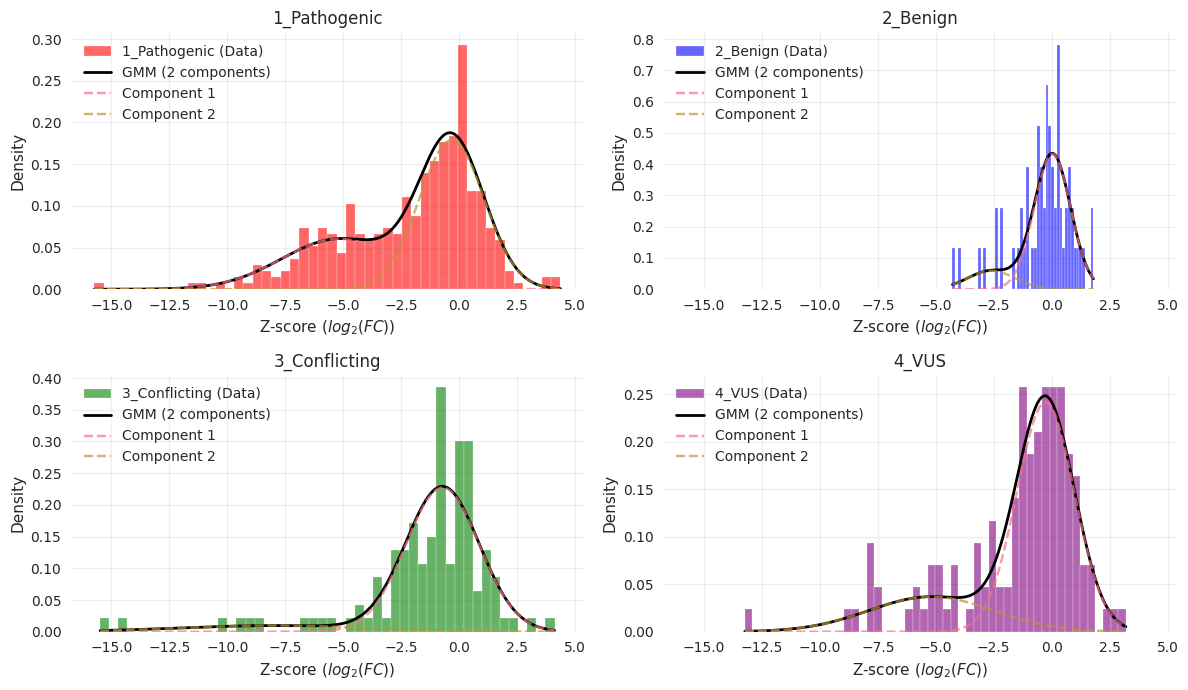

=== GAUSSIAN MIXTURE MODEL ANALYSIS REPORT ===
1. MODEL FITTING RESULTS:
1_Pathogenic:"
  - Optimal components: 2
  - BIC score: 1665.06
  - Component means: [-5.18484685 -0.32069845]
  - Component weights: [0.37349619 0.62650381]
2_Benign:"
  - Optimal components: 2
  - BIC score: 213.45
  - Component means: [ 0.03265752 -2.60898695]
  - Component weights: [0.84982023 0.15017977]
3_Conflicting:"
  - Optimal components: 2
  - BIC score: 548.99
  - Component means: [-0.71534199 -7.9945434 ]
  - Component weights: [0.9005392 0.0994608]
4_VUS:"
  - Optimal components: 2
  - BIC score: 600.32
  - Component means: [-0.26067975 -5.19936167]
  - Component weights: [0.75218062 0.24781938]
2. COMPARISON WITH NULL (2_Benign):
1_Pathogenic:
  - KL Divergence from null: 1.7280
  - Number of extra peaks: 1
    Peak 1: mean=-5.18, weight=0.373
3_Conflicting:
  - KL Divergence from null: 0.9385
  - Number of extra peaks: 0
4_VUS:
  - KL Divergence from null: 1.0948
  - Number of extra peaks: 1
    Pe

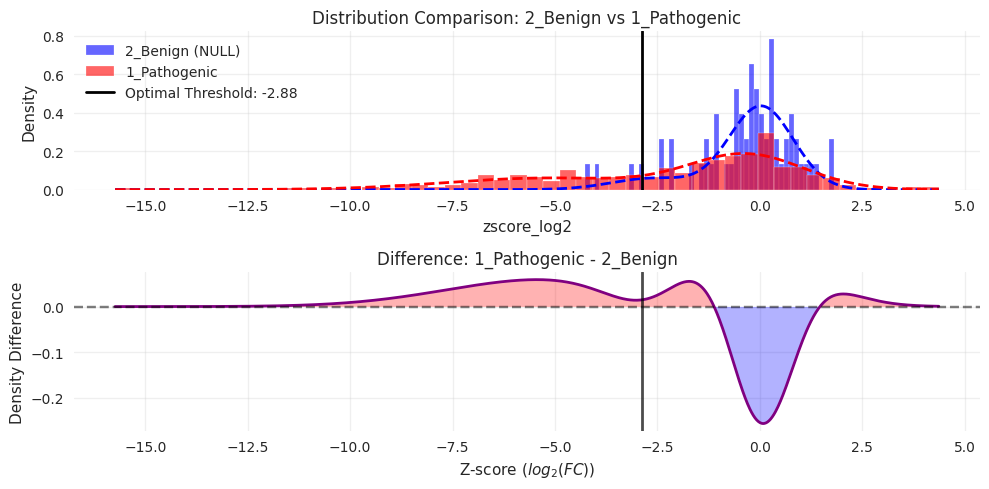

Threshold Analysis Results:
Optimal Threshold: -2.884
2_Benign Accuracy: 0.937
1_Pathogenic Accuracy: 0.342
Overall Accuracy: 0.639


In [45]:
clinvar_data_dict = {
    '1_Pathogenic': scores.filter(pl.col('clinvar_clnsig_clean')=='1_Pathogenic')['zscore_log2'].to_numpy(),
    '2_Benign': scores.filter(pl.col('clinvar_clnsig_clean')=='2_Benign')['zscore_log2'].to_numpy(),
    '3_Conflicting': scores.filter(pl.col('clinvar_clnsig_clean')=='3_Conflicting')['zscore_log2'].to_numpy(),
    '4_VUS': scores.filter(pl.col('clinvar_clnsig_clean')=='4_VUS')['zscore_log2'].to_numpy(),
}

# Initialize analyzer
analyzer = DistributionAnalyzer(clinvar_data_dict)

# Fit GMM models for all categories
print("Fitting Gaussian Mixture Models...")
analyzer.fit_all_categories()

# Plot distributions with GMM fits
print("Plotting distributions with GMM overlays...")
analyzer.plot_distributions_with_gmm()

# Generate comprehensive report
analyzer.generate_summary_report()

# Compare specific categories with threshold analysis
print("\n=== THRESHOLD ANALYSIS ===")
categories_to_compare = ['1_Pathogenic', '3_Conflicting', '4_VUS']

for category in categories_to_compare[:1]:
    print(f"Analyzing {category} vs 2_Benign:")
    analyzer.plot_comparison_with_threshold('2_Benign', category, figsize=(10,5))

### Find optimal threshold using: `find_gmm_threshold_mahalanobis`

This function estimates an optimal threshold for identifying outliers (e.g., pathogenic variants) using **Mahalanobis distance** computed from a **Gaussian Mixture Model (GMM)** fitted on a reference (null) distribution—typically benign variants.

---

### Overview

- **Purpose**: To define a robust, data-driven threshold for classification.
- **Key Assumption**: Benign variants form a distribution that can be modeled as a GMM.
- **Outliers**: Points that deviate significantly from this distribution (high Mahalanobis distance) are likely pathogenic.

---

### Parameters

- `null_category` *(str)*: Label of the class representing the null distribution (default: `"2_Benign"`).
- `chi2_percentile` *(float)*: Percentile of the chi-squared distribution to determine the threshold (default: `95`).
- `min_component_weight` *(float)*: GMM components with weights below this threshold are ignored (default: `0.05`).

---

### Step-by-Step Logic

#### 1. Fit GMM (if not already fitted)
- If a GMM is not yet fitted for the specified null category, it is trained.
- Input data for the null category is retrieved.

#### 2. Compute Mahalanobis Distances
- For each significant GMM component (weight ≥ `min_component_weight`):
  - Compute Mahalanobis distance (1D case):  
    $D_M(x) = \frac{|x - \mu|}{\sigma}$
  - Collect all such distances.

#### 3. Convert to Squared Mahalanobis Distances
- Squared distances follow a chi-squared distribution with 1 degree of freedom:
  $D^2_M(x) \sim \chi^2_{(1)}$

#### 4. Determine Threshold
- **Chi-squared threshold**: From theoretical distribution:
  $T_{\chi^2} = {\chi^2}_{1}^{-1}(p)$
- **Empirical threshold**: Percentile of the actual squared distances.
- **Final threshold**: Use the maximum of the two (conservative choice):
  $T = \max(T_{\chi^2}, T_{\text{empirical}})$

#### 5. Convert Back to Score Space
- Use the **main component** (highest GMM weight) to convert threshold:
  $|x - \mu| = \sigma \cdot \sqrt{T} \Rightarrow x = \mu - \sigma \cdot \sqrt{T}$
- Assumes that outliers lie in the **left tail** of the distribution.

---

### Returns

A dictionary containing:
- `'threshold'`: Score cutoff separating null from outliers.
- `'mahalanobis_sq_threshold'`: Final squared Mahalanobis threshold.
- `'chi2_threshold'`: Threshold based on chi-squared distribution.
- `'empirical_threshold'`: Empirical threshold from data.
- `'main_component'`: GMM component used for final conversion.
- `'all_components'`: All valid GMM components considered.
- `'method'`: Identifier string for traceability (`"mahalanobis_gmm"`).

---

### Advantages

- **Robust to small sample sizes**
- **Effective with imbalanced data**
- **Accounts for distribution variance**
- **Handles heterogeneity via GMM components**

In [24]:
thresh = analyzer.find_optimal_threshold()
thresh

Auto-selected 'mahalanobis' method (null sample size: 63)


{'threshold': -2.884438034613693,
 'prior': 0.8432835820895522,
 'null_accuracy': 0.9365079365079365,
 'target_accuracy': 0.3421828908554572,
 'overall_accuracy': 0.6393454136816968,
 'specificity': 0.9365079365079365,
 'sensitivity': 0.3421828908554572,
 'aubprc': 0.7174036002082943,
 'raw_auprc': 0.931787962840664,
 'method_used': 'mahalanobis',
 'main_component_mean': 0.032657516453014644,
 'main_component_std': 0.7827161623189357,
 'main_component_weight': 0.8498202271671143,
 'mahalanobis_sq_threshold': 13.889694910327268,
 'chi2_threshold': 3.841458820694124,
 'empirical_threshold': 13.889694910327268,
 'chi2_percentile': 95,
 'sample_sizes': {'null': 63, 'target': 339}}

Auto-selected 'mahalanobis' method (null sample size: 63)
# of Benign variants: 63
# of Pathogenic variants: 339
# of VUS variants: 130
# of Conflicting variants: 119


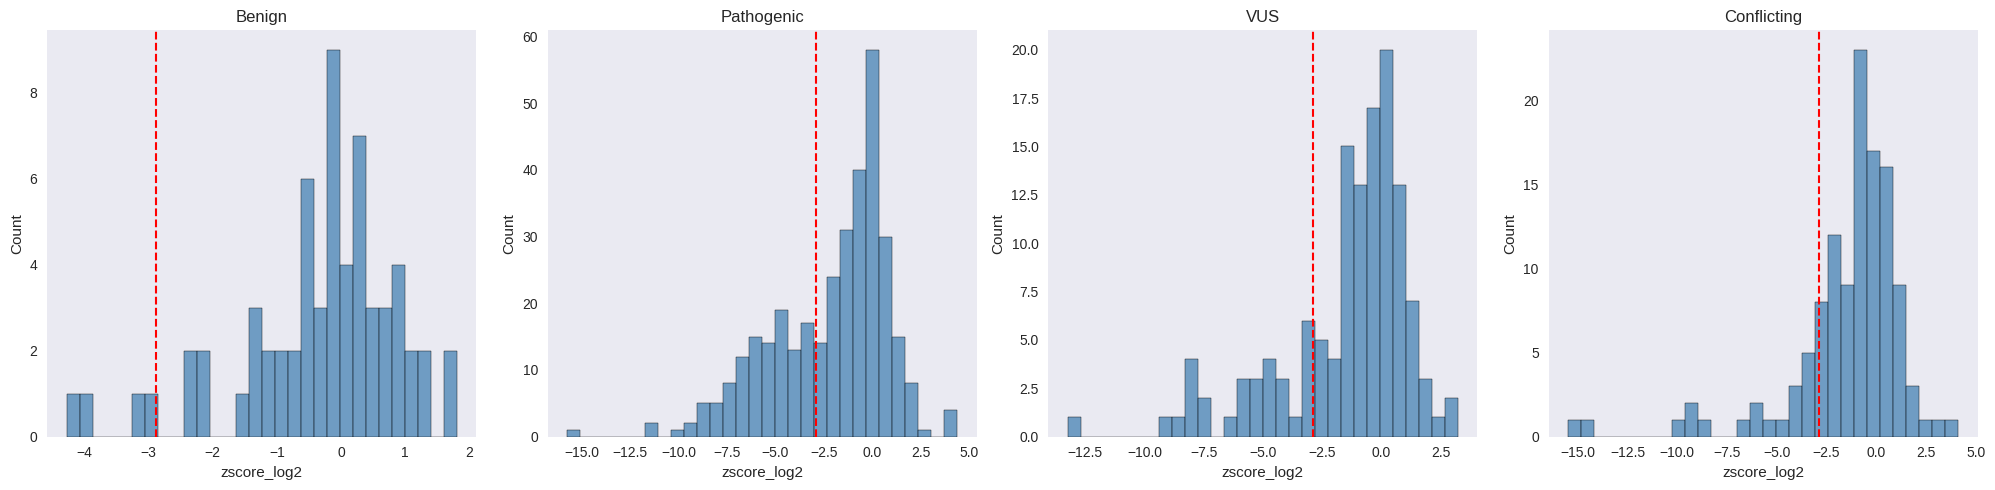

Optimal thresh found at -2.884
With this threshold, we classify 23.077% VUS,
AND 16.807% conflicting alleles as pathogenic.
This threshold classifies 6.349% of benign variants as pathogenic


In [25]:
plot_var = "zscore_log2"
optimal_threshold = analyzer.find_optimal_threshold()["threshold"]

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")
print("# of Benign variants:", benign_scores.shape[0])

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic")
print("# of Pathogenic variants:", path_scores.shape[0])

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS")
print("# of VUS variants:", vus_scores.shape[0])

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting")
print("# of Conflicting variants:", conf_scores.shape[0])

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x=plot_var, bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(optimal_threshold, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel(plot_var)
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

benign_misclass = benign_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]
benign_total = benign_scores.shape[0]
print(f"Optimal thresh found at {optimal_threshold:.3f}")
print(f"With this threshold, we classify {vus_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]/vus_scores.shape[0]*100:.3f}% VUS,")
print(f"AND {conf_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]/conf_scores.shape[0]*100:.3f}% conflicting alleles as pathogenic.")
print(f"This threshold classifies {benign_misclass/benign_total*100:.3f}% of benign variants as pathogenic")
# This is ~13.4% of VUS/conflicting

In [30]:
scores = scores.with_columns(
    pl.when(pl.col(plot_var)<optimal_threshold)
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("dualipa_abund_change"),
    pl.lit(True).alias("dualipa_assayed"),
    pl.lit(optimal_threshold).alias("dualipa_threshold"),
    pl.col("zscore_log2").alias("abund_zscore")
)

In [31]:
scores

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64,f64
"""KCNJ2""","""899G>A""","""Gly300Asp""","""KCNJ2_Gly300Asp""",693.679993,5069.049805,0.133067,0.841771,0.15808,-1.835174,-1.0,-5.882805,"""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""","""VUSmut_GDEh03""","""H09""",1,2,1,2,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.882805
"""HBD""","""174C>A""","""Asn58Lys""","""HBD_Asn58Lys""",33.84,2474.280029,0.012192,0.077713,0.156882,-1.837623,-1.0,-5.907103,"""ENSG00000223609""","""CCSBVarC006560""","""ALE00006559""","""NC_000011.10:5234132:G:T""","""CEGS2""","""CegsMutGDEh1047""","""D02""","""GDEhDisVCh_40036""","""D03""","""2""","""CegsMutGDDh1047""","""D02""","""VUSN2Hmut_GDN2h_10""","""C04""","""VUSMutpDEST2_11""","""H05""","""VUSmut_GDEh10""","""C04""",1,1,1,1,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.907103
"""SMAD3""","""376C>T""","""His126Tyr""","""SMAD3_His126Tyr""",993.600037,3757.339966,0.267095,1.033889,0.25834,-1.630252,-1.0,-4.313822,"""ENSG00000166949""","""CCSBVarC007714""","""ALE00007700""","""NC_000015.10:67165064:C:T""","""Edgotyping3""","""VUSMutGDEh004""","""D11""","""GDEhDisVCh_40014""","""D06""","""2""","""VUSMutGDDh004""","""D11""","""NULL""","""NULL""","""VUSMutpDEST2_09""","""B02""","""NULL""","""NULL""",1,1,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-4.313822
"""HBD""","""110C>A""","""Pro37His""","""HBD_Pro37His"

In [32]:
## only keep the non-nulls
scores.write_csv(f"{dualipa_outputs}/annotated_perturbation_scores.csv")
scores.write_csv(f"{integrative_inputs}/abun_scores.csv")